In [1]:
#IMPORTAR PACKAGES y LIBRARYS

#Librerías útiles
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import strptime
from scipy.signal import periodogram
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from itertools import combinations
from dateutil.relativedelta import relativedelta
from tqdm.notebook import tqdm
from pmdarima.utils import diff_inv
#otros
import warnings
warnings.filterwarnings("ignore")

#Modelos de Pruebas Estadísticas
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tools.eval_measures import mse,rmse,rmspe,bias,meanabs
import statsmodels.tsa.stattools as ts

#Modelos predictivos estadísticos
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import VAR

#Configuraciones
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#DICCIONARIOS, OBJETOS
dic_mes = {
        'Enero': 1,
        'Febrero': 2,
        'Marzo': 3,
        'Abril':4,
         'Mayo':5,
         'Junio':6,
         'Julio':7,   
         'Agosto':8,
         'Setiembre':9,
         'Octubre':10,
         'Noviembre':11,
         'Diciembre':12
        }


In [3]:
#PREPARACIÓN_DATA

df= pd.read_excel("C:/Users/Usuario/OneDrive - prediqtdata.com/Desktop/Renato/Python/script atenea/consolidado_moderno.xlsx"
,sheet_name="Salsas")
df.replace(dic_mes, inplace=True)
df['Quarter'] = df['MES'].apply(lambda x: 'Quarter1' if x in [1, 2, 3] else 'Quarter2' if x in [4, 5, 6] else 'Quarter3' if x in [7, 8, 9] else 'Quarter4')
df['Month_in_Quarter'] = df['MES'].apply(lambda x: 1 if x % 3 == 1 else 2 if x % 3 == 2 else 3)
df["PERIODO"]= df["AÑO"].astype(str)+"-"+df["MES"].astype(str)

df['PERIODO'] = pd.to_datetime(df['PERIODO'])    
#df['PERIODO'] = df['PERIODO'].dt.to_period('M')
df = df.set_index('PERIODO')

cols=['PERIODO','AÑO','MES','Quarter','Month_in_Quarter','OFICINA DE VENTAS'
      ,'VENTA SELL IN', 'VENTA SELL OUT TOTAL'
      , 'SHARE VOLUMEN ALICORP', 'SHARE VOLUMEN MERCADO'
      ,'SHARE % ALICORP','SHARE % MERCADO']

cols_data =['VENTA SELL IN'
      , 'VENTA SELL OUT TOTAL'
      #, 'SHARE VOLUMEN ALICORP'
      #,'SHARE VOLUMEN MERCADO'
      #,'SHARE % ALICORP'
      #,'SHARE % MERCADO'
      ]


df_ini=df[cols_data]
df_ini




,VENTA SELL IN,VENTA SELL OUT TOTAL
PERIODO,,
2019-01-01,680.000000,487.000000
2019-02-01,434.000000,450.000000
2019-03-01,640.000000,462.000000
2019-04-01,562.000000,458.000000
2019-05-01,651.000000,489.000000
2019-06-01,603.000000,482.000000
2019-07-01,577.000000,544.000000
2019-08-01,467.000000,485.000000
2019-09-01,616.000000,527.000000


  0%|          | 0/18 [00:00<?, ?it/s]

Text(0.5, 1.0, 'VAR, MSE: 54,150.0')

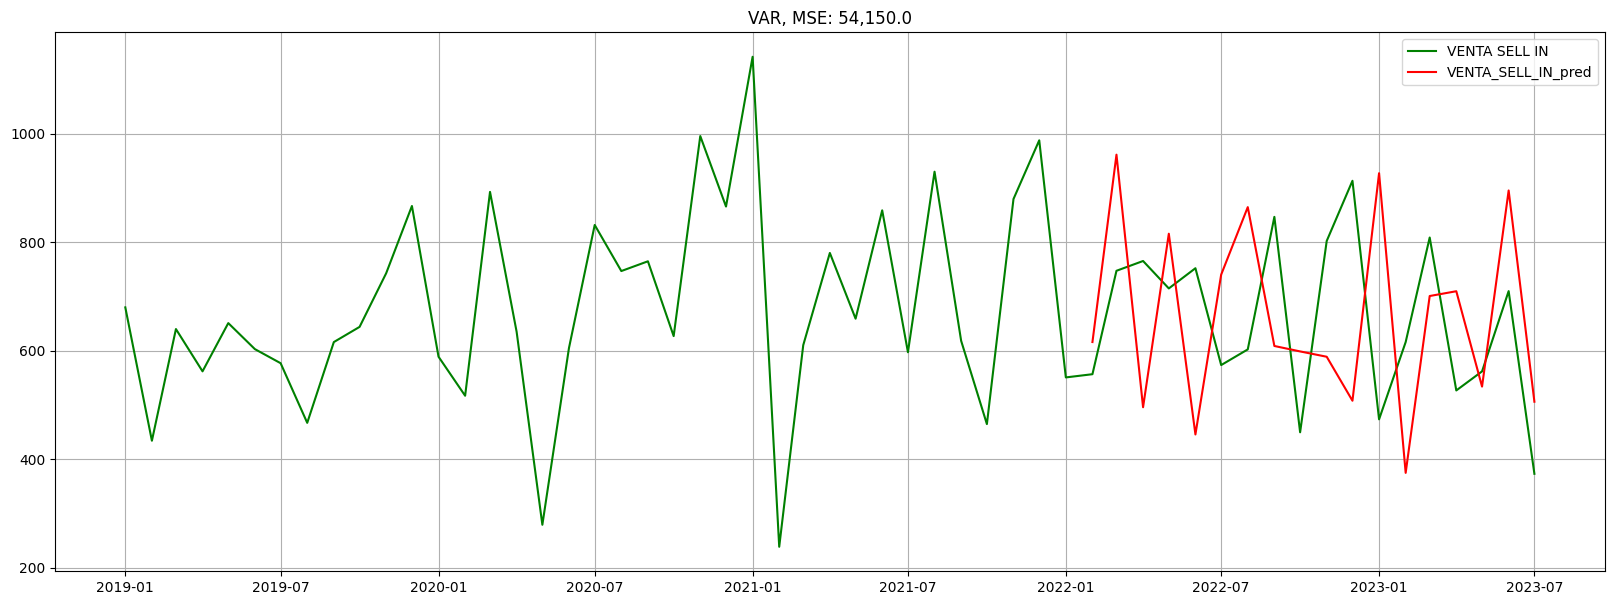

MAPE: 0.325


In [6]:

df_var = df_ini
                                           
df_1D=df_var.diff().dropna()

df_2D=df_1D.diff().dropna()

pred_dict = {'date':[], 'VENTA_SELL_IN_2D':[], 'ci_lower':[],'ci_upper':[] }

nobs= 18

for i in tqdm(range(nobs)):
    
    training_data = df_2D[:(-nobs+i)]
    
    # VAR model selects lag p based on AIC
    
    model = VAR(training_data)
    model_fit = model.fit(ic = 'aic')
    model_results = model_fit.forecast_interval( y=training_data.to_numpy() , steps=1)

    pred_date = training_data.index[-1] + relativedelta(months = 1)
    pred_dict['date'].append(pred_date)
    pred_dict['VENTA_SELL_IN_2D'].append(model_results[0][0][0])
    pred_dict['ci_lower'].append(model_results[1][0][0])
    pred_dict['ci_upper'].append(model_results[2][0][0])



# transform data
df_pred = pd.DataFrame(pred_dict)
df_pred = df_pred.set_index('date')


df_pred= pd.concat([df_var,df_pred],axis=1,join="outer")
df_pred= df_pred.assign(VENTA_SELL_IN_1D= None)
df_pred= df_pred.assign(VENTA_SELL_IN_pred= None)


n=df_pred.shape[0]
#print(n)
#print(df_pred['VENTA_SELL_IN_2D'][31] )
#print(df_pred["VENTA SELL IN"].iloc[2+1])
#print(df_pred["VENTA SELL IN"].iloc[2])



for i in range(0,n):
    df_pred["VENTA_SELL_IN_1D"][i] = (df_pred["VENTA SELL IN"].iloc[i-1] - df_pred["VENTA SELL IN"].iloc[i-2]) + df_pred['VENTA_SELL_IN_2D'][i]


for i in range(0,n):
    df_pred["VENTA_SELL_IN_pred"][i] = df_pred["VENTA SELL IN"].iloc[i-1] + df_pred["VENTA_SELL_IN_1D"][i]


plt.plot(df_pred['VENTA SELL IN'], color = 'green')
plt.plot(df_pred['VENTA_SELL_IN_pred'], color = 'red')
plt.legend(['VENTA SELL IN', 'VENTA_SELL_IN_pred'])
#plt.fill_between(df_pred.index,
#                 df_pred['ci_lower'],
#                 df_pred['ci_upper'], color='lightblue', alpha=0.5)
plt.title('VAR, MSE: {:,}'.format(round(mean_squared_error(
    df_pred['VENTA SELL IN'][-nobs:], df_pred['VENTA_SELL_IN_pred'][-nobs:]), 2)))
plt.grid()
plt.show()
MAPE= mean_absolute_percentage_error(df_pred['VENTA SELL IN'][-nobs:], df_pred['VENTA_SELL_IN_pred'][-nobs:])
print("MAPE:", round(MAPE,3))